In [40]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [2]:
! pip install pyconll
! pip install pydot
!pip install graphviz
!pip install bert-tensorflow==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 5.9 MB/s 


In [3]:
from numpy.random import seed
seed(1)

import tensorflow as tf    
tf.random.set_seed(1)
from tensorflow import keras
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score


from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical


import tensorflow_hub as hub

from bert.tokenization import FullTokenizer

from tqdm import tqdm_notebook
from IPython.display import Image 


In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [6]:
def plot_acc():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [7]:
def plot_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [8]:
UD_ENGLISH_TRAIN = 'en_partut-ud-train.conllu'
UD_ENGLISH_DEV = 'en_partut-ud-dev.conllu'
UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

In [9]:
from six.moves import urllib
def download_files():
    print('Downloading English treebank...')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-dev.conllu', 'en_partut-ud-dev.conllu')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-test.conllu', 'en_partut-ud-test.conllu')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-train.conllu', 'en_partut-ud-train.conllu')
    print('Treebank downloaded.')

In [10]:
download_files()

Treebank downloaded.


In [11]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

In [12]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

In [13]:

print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  1781
Tagged words in train set: 43518
Tagged sentences in dev set:  156
Tagged words in dev set: 2722
Tagged sentences in test set:  153
Tagged words in test set: 3408
****************************************
Total sentences in dataset: 2090


In [14]:
print(train_sentences[0])

[('distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]


In [15]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

In [16]:

tags = set([item for sublist in train_sentences+test_sentences+val_sentences for _, item in sublist])
print('TOTAL TAGS: ', len(tags))

TOTAL TAGS:  17


In [17]:
tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i+1
    int2tag[i+1] = tag

In [18]:
tag2int['-PAD-'] = 0
int2tag[0] = '-PAD-'

In [19]:

n_tags = len(tag2int)
print('Total tags:', n_tags)

Total tags: 18


In [20]:
list(tag2int)

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '-PAD-']

In [21]:
MAX_SEQUENCE_LENGTH = 70
EPOCHS = 30

In [22]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

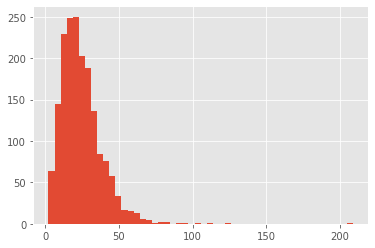

In [23]:

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [24]:
print('Max sentence length:',len(max(train_sentences+val_sentences, key=len)))

Max sentence length: 209


In [25]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new

In [26]:
train_sentences = split(train_sentences, MAX_SEQUENCE_LENGTH)
val_sentences = split(val_sentences, MAX_SEQUENCE_LENGTH)
test_sentences = split(test_sentences, MAX_SEQUENCE_LENGTH)

In [27]:
len(max(train_sentences+val_sentences, key=len))

70

In [28]:
train_sentences = train_sentences + val_sentences

In [29]:
sess = tf.compat.v1.Session()
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/2"

In [30]:
train_text = text_sequence(train_sentences)
test_text = text_sequence(test_sentences)
#val_text = text_sequence(val_sentences)

train_label = tag_sequence(train_sentences)
test_label= tag_sequence(test_sentences)
#val_label= tag_sequence(val_sentences)

In [31]:

len(train_text)

1951

In [32]:
train_text[0], train_label[0]

(['distribution',
  'of',
  'this',
  'license',
  'does',
  'not',
  'create',
  'an',
  'attorney',
  '-',
  'client',
  'relationship',
  '.'],
 ['NOUN',
  'ADP',
  'DET',
  'NOUN',
  'AUX',
  'PART',
  'VERB',
  'DET',
  'NOUN',
  'PUNCT',
  'NOUN',
  'NOUN',
  'PUNCT'])

In [33]:

# Params for bert model and tokenization
# bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False)
    
    vocab_file = bert_module.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_module.resolved_object.do_lower_case.numpy()
    return FullTokenizer(vocab_file,  do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label_ids = [0] * max_seq_length
        return input_ids, input_mask, segment_ids, label_ids
    
    tokens_a = example.text_a
    if len(tokens_a) > max_seq_length-2:
        tokens_a = tokens_a[0 : (max_seq_length-2)]

# Token map will be an int -> int mapping between the `orig_tokens` index and
# the `bert_tokens` index.

# bert_tokens == ["[CLS]", "john", "johan", "##son", "'", "s", "house", "[SEP]"]
# orig_to_tok_map == [1, 2, 4, 6]   
    orig_to_tok_map = []              
    tokens = []
    segment_ids = []
    
    tokens.append("[CLS]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    #print(len(tokens_a))
    for token in tokens_a:       
        tokens.extend(tokenizer.tokenize(token))
        orig_to_tok_map.append(len(tokens)-1)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])
    #print(len(orig_to_tok_map), len(tokens), len(input_ids), len(segment_ids)) #for debugging

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)
    
    label_ids = []
    labels = example.label
    label_ids.append(0)
    label_ids.extend([tag2int[label] for label in labels])
    label_ids.append(0)
    #print(len(label_ids)) #for debugging
    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
        label_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    assert len(label_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, label_ids

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [39]:

tokenizer = create_tokenizer_from_hub_module()

AttributeError: ignored

In [ ]:
# orig_tokens = ["John", "Johanson", "'s",  "house"]
# labels      = ["NNP",  "NNP",      "POS", "NN"]
# bert_tokens = ['[CLS]", "john", "johan", "##son", "'",   "s",  "house", "[SEP]"]
# bert_labels = ['[CLS]", "NNP",  "NNP",   "##",    "POS", "##", "NN",    "[SEP]"] 

In [ ]:
def bert_labels(labels):
    train_label_bert = []
    train_label_bert.append('-PAD-')
    for i in labels:
        train_label_bert.append(i)
    train_label_bert.append('-PAD-')
    print('BERT labels:', train_label_bert)  

In [ ]:

tokens_a = train_text[2]

In [ ]:
orig_to_tok_map = []              
tokens = []
segment_ids = []
tokens.append("[CLS]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
for token in tokens_a:
    #orig_to_tok_map.append(len(tokens)) # keep first piece of tokenized term
    tokens.extend(tokenizer.tokenize(token))
    orig_to_tok_map.append(len(tokens)-1) # # keep last piece of tokenized term -->> gives better results!
    segment_ids.append(0)
tokens.append("[SEP]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])